## Context

Banks incur significant losses due to default in loans. This has led to a tightening up of loan underwriting and has increased loan rejection rates. The need for a better credit risk scoring model is also raised by banks.

The CNK bank has collected customer data for the past few years and wants to build a model to predict if a customer coming to purchase a loan is a good customer (will not default) or a bad customer (will default).


## Data Dictionary

- month - the month of purchase
- credit_amount - amount for which loan is requested
- credit_term - for how long customer wants a loan
- age - age of the customer
- sex - gender of the customer
- education - education level of customer
- product_type - for purchasing what type of product does the customer need a loan (0, 1, 2, 3, 4)
- having_children_flg - if the customer has children or not
- region - customer region category (0, 1, 2)
- income - income of the customer
- family_status - another, married, unmarried
- phone_operator - mobile operator category (0, 1, 2, 3)
- is_client - if the customer wanting to purchase a loan is our client or not
- target - 1-bad customer (positive class), 0-good customer (negative class)




## Import Libraries

In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_sklearn(model, predictors, target, threshold=0.5):
    # predicting using the independent variables
    pred = model.predict_proba(predictors)[:,1] > threshold

    acc = accuracy_score(target, pred)  # to compute Accuracy
    b_acc = balanced_accuracy_score(target, pred) # balanced accuracy: average of recall obtained on each class
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score
    auc = roc_auc_score(target, model.predict_proba(predictors)[:,1])

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Balanced Accuracy": b_acc,
                            "Recall": recall, "Precision": precision,
                            "F1": f1, "AUC": auc}, index=[0],)
    return df_perf

## Load and view dataset

In [3]:
df = pd.read_csv("Loanclients.csv")

In [4]:
data = df.copy()

In [5]:
data.head()

,Month,credit_amount,credit_term,Age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,target
0,10,7000,6,25,0,Secondary special education,1,0,0,21000.0,1,0,0,0
1,10,19000,3,54,0,Secondary special education,3,1,1,17000.0,1,3,0,0
2,1,29000,2,36,0,Secondary special education,1,0,2,31000.0,1,2,0,0
3,11,10000,6,46,0,Secondary special education,0,1,1,31000.0,1,3,0,0
4,4,14500,4,39,0,Higher education,1,0,1,26000.0,1,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Month                1000 non-null   int64  
 1   credit_amount        1000 non-null   int64  
 2   credit_term          1000 non-null   int64  
 3   Age                  1000 non-null   int64  
 4   sex                  1000 non-null   int64  
 5   education            1000 non-null   object 
 6   product_type         1000 non-null   int64  
 7   having_children_flg  1000 non-null   int64  
 8   region               1000 non-null   int64  
 9   income               967 non-null    float64
 10  family_status        1000 non-null   int64  
 11  phone_operator       1000 non-null   int64  
 12  is_client            1000 non-null   int64  
 13  target               1000 non-null   int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 109.5+ KB


In [7]:
# checking missing values in the data
data.isna().sum()

Month                   0
credit_amount           0
credit_term             0
Age                     0
sex                     0
education               0
product_type            0
having_children_flg     0
region                  0
income                 33
family_status           0
phone_operator          0
is_client               0
target                  0
dtype: int64

**The income variable has some missing values, we will impute them later**

In [8]:
# change region, phone_operator, and product_type into category datatype
data["region"] = data["region"].astype("category")
data["phone_operator"] = data["phone_operator"].astype("category")
data["product_type"] = data["product_type"].astype("category")

In [9]:
# checking the distribution of the target variable
data["target"].value_counts(normalize=True)

0    0.893
1    0.107
Name: target, dtype: float64

### Splitting the data into X and y

In [10]:
# separating the independent and dependent variables
X = data.drop(["target"], axis=1)
y = data["target"]

# creating dummy variables (for tree-based models like Decision Tree and Random Forest, we don't need to delete one of the columns of the dummy variables)
X = pd.get_dummies(X)

## Training and Testing datasets

![image](img/train_test.png)

## Training, Validation and Testing datasets

![image](img/train_val_test.png)

In [11]:
# Splitting data into training, validation and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)
print(X_train.shape, X_test.shape)

(800, 34) (200, 34)


## Data leakage

* Data leakage in machine learning occurs when information from the testing or validation set accidentally leaks into the training set.
* Types of data leakage include target leakage, train-test contamination, data preprocessing, and feature leakage.
* Target leakage occurs when information used to construct the target variable would not be available at prediction time.
* Train-test contamination occurs when data from the testing or validation set ends up in the training set.
* Data preprocessing can also cause data leakage if information from the testing or validation set is used for training.
* Feature leakage occurs when features not available at prediction time are used to train the model.
* Techniques like cross-validation, proper data shuffling, and feature engineering can help prevent data leakage.

In [12]:
# Let's impute the missing values
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")

# fit the imputer on train data and transform the train data
X_train["income"] = imp_median.fit_transform(X_train[["income"]])

# transform the test data using the imputer fit on train data
X_test["income"] = imp_median.transform(X_test[["income"]])

In [13]:
# Checking class balance for whole data, train set, validation set, and test set
print("Target value ratio in y")
print(y.value_counts(normalize=True))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(normalize=True))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(normalize=True))
print("*" * 80)

Target value ratio in y
0    0.893
1    0.107
Name: target, dtype: float64
********************************************************************************
Target value ratio in y_train
0    0.8925
1    0.1075
Name: target, dtype: float64
********************************************************************************
Target value ratio in y_test
0    0.895
1    0.105
Name: target, dtype: float64
********************************************************************************


# DecisionTreeClassifier

![image](img/decision_tree.png)

### DecisionTreeClassifier with default parameters

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

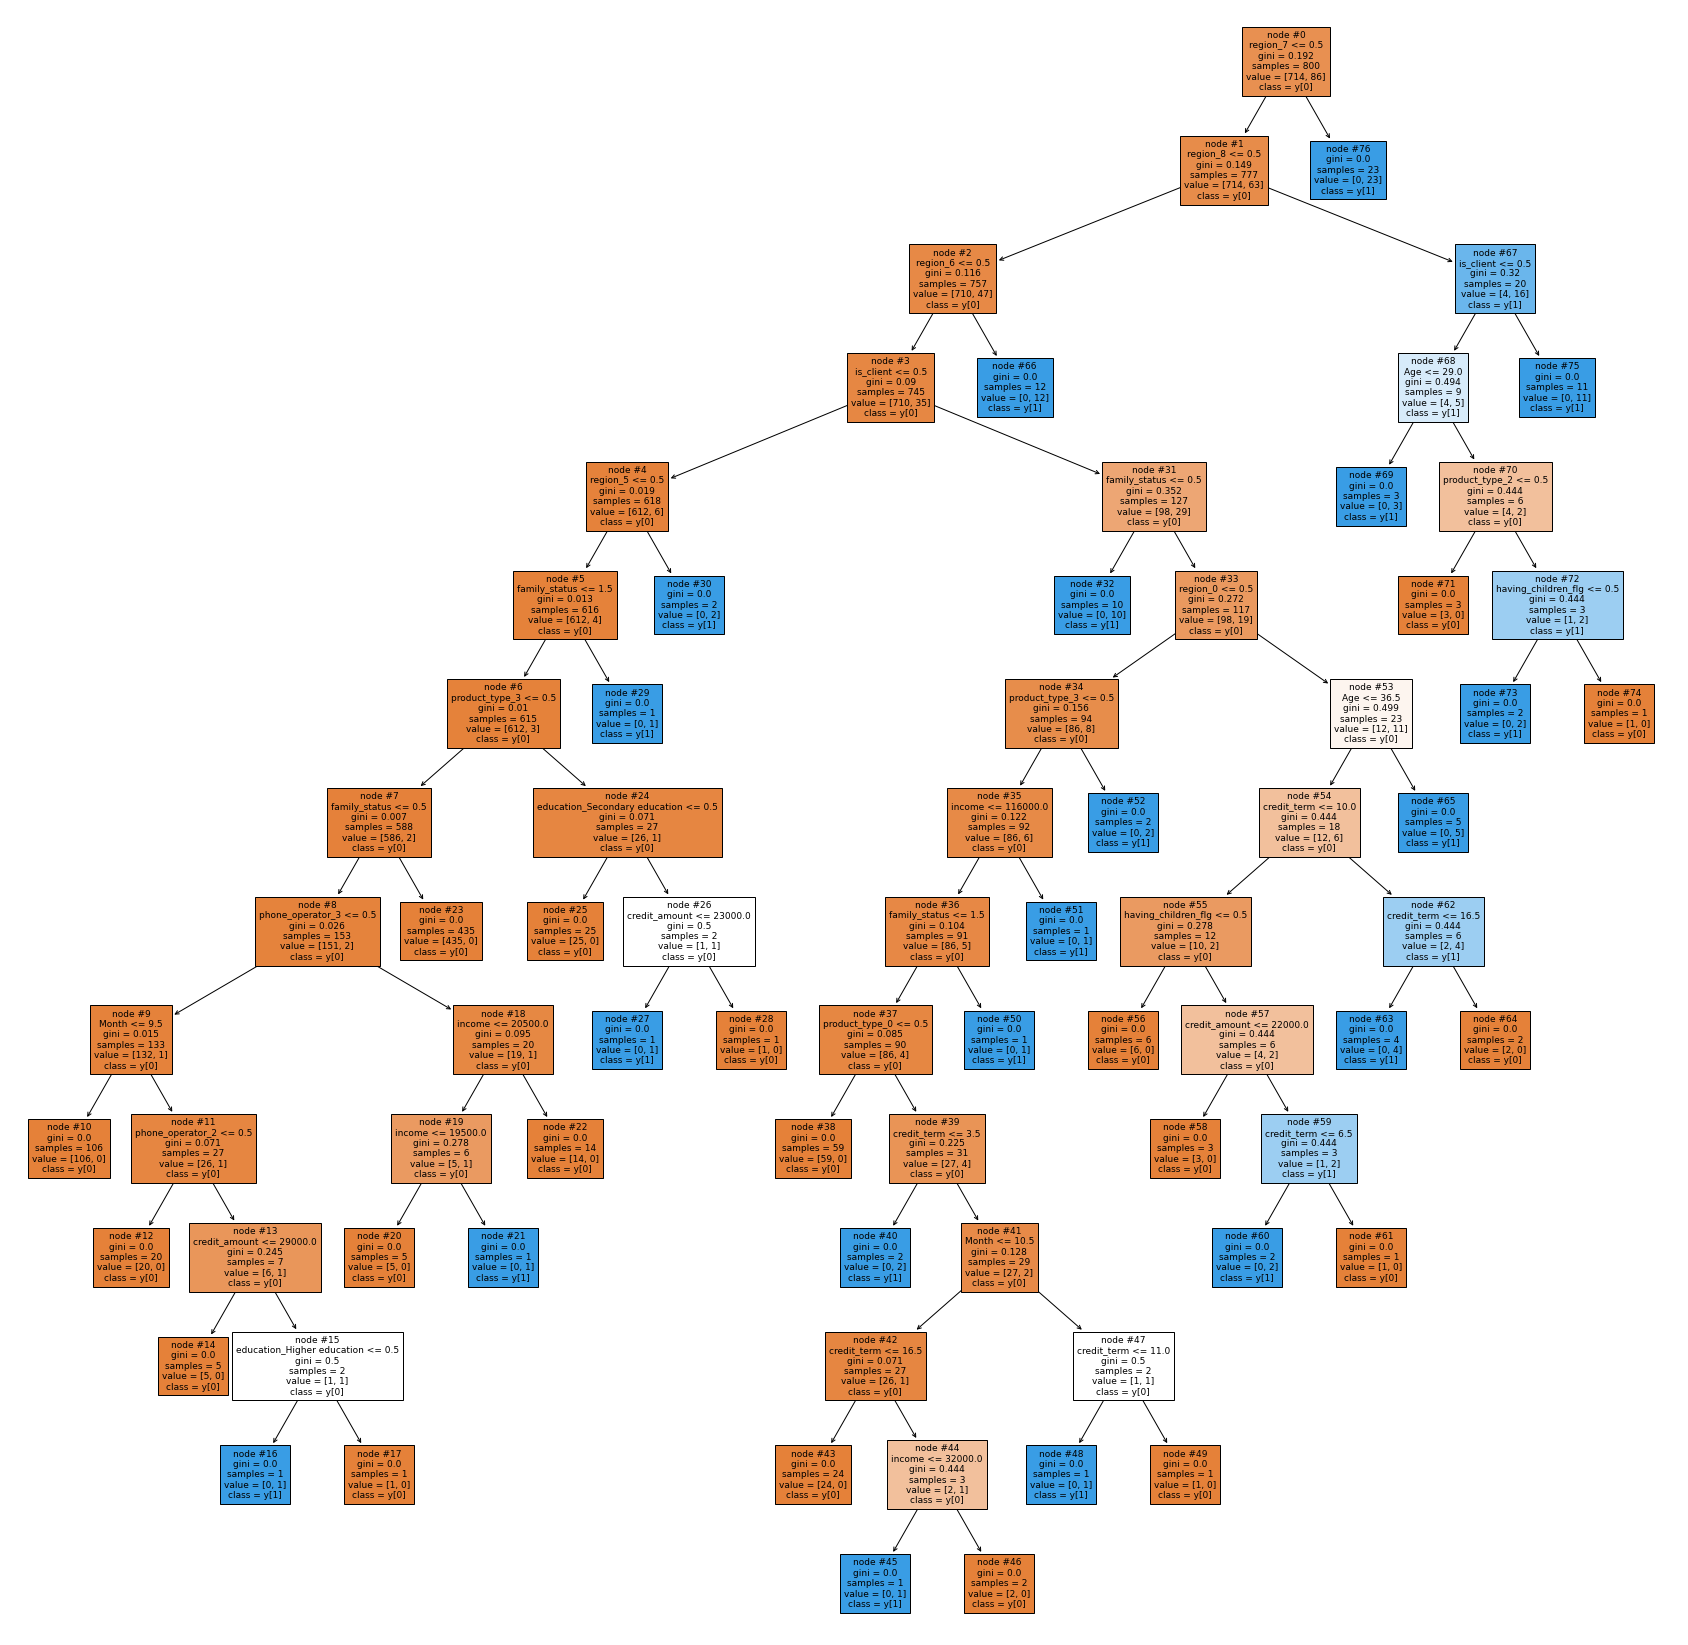

CPU times: total: 5.2 s
Wall time: 5.68 s


In [15]:
%%time
plt.figure(figsize=(30, 30))
plot_tree(dt, feature_names=X_train.columns.to_list(), filled=True, fontsize=9, node_ids=True, class_names=True)
plt.show()

## Model evaluation criterion


**What does a bank want?**
* A bank wants to minimize the loss - it can face 2 types of losses here: 
   * Whenever a bank lends money to a customer, they don't return it.
   * A bank doesn't lend money to a customer thinking a customer will default but in reality, the customer won't - opportunity loss.

- Positive class - customer who would default (bad customer)

- Negative class - customer who wouldn't default (good customer)

**Which loss is greater?**
* Lending to a customer who wouldn't be able to pay back.

**Since we want to reduce loan defaults we should use Recall as the main metric of model evaluation. However, we also don't want to predict that every customer would default, so Precision has to be considered as well.**


* Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e., low chances of predicting a bad customer as a good customer.
* Precision - It gives the ratio of True positives to Predicted positives, so high Precision implies low false positives, i.e., low chances of predicted a good customer as a bad customer.

In [16]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
dt_train_perf = model_performance_classification_sklearn(dt, X_train, y_train, threshold=0.5)
display(dt_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
dt_test_perf = model_performance_classification_sklearn(dt, X_test, y_test, threshold=0.5)
display(dt_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,1.0,1.0,1.0,1.0,1.0,1.0


Evaluation metrics on the testing dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.965,0.875366,0.761905,0.888889,0.820513,0.875366


## Cross validation

![image](img/cross_validation.png)

## Hyperparameter Tuning

### Hyperparameters for DecisionTreeClassifier

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Grid Search CV
* Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search
* Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
* It is an exhaustive search that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [18]:
%%time

# Choose the type of classifier. 
dt1 = DecisionTreeClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    # The maximum depth of the tree. If None, then nodes 
    # are expanded until all leaves are pure or until all leaves 
    # contain less than min_samples_split samples.
    "max_depth": np.arange(3, 9),
    # The minimum number of samples required to split an internal node
    "min_samples_split": [5, 10, 30, 50, 70],
    # The minimum number of samples required to be at a leaf node
    "min_samples_leaf": [5, 10, 15, 20],
    # The number of features to consider when looking for the best split
    "max_features": ['auto', 'sqrt', 'log2'],
    # Grow a tree with max_leaf_nodes in best-first fashion
    "max_leaf_nodes": [10, 25, 50, 100],
    # Weights associated with classes
    "class_weight": [{0:0.1, 1:0.9}, {0:0.05, 1:0.95}, {0:0.2, 1:0.8}]
    
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj_dt1 = GridSearchCV(dt1, parameters, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search

grid_obj_dt1 = grid_obj_dt1.fit(X_train, y_train)

# Print the best combination of parameters
grid_obj_dt1.best_params_

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
CPU times: total: 14.3 s
Wall time: 48 s


{'class_weight': {0: 0.05, 1: 0.95},
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 5}

In [38]:
6*5*4*3*4*3*5

21600

In [19]:
# use the best combination of parameters to train the model
dt1_tuned = DecisionTreeClassifier(
            min_samples_split = grid_obj_dt1.best_params_['min_samples_split'],
            min_samples_leaf = grid_obj_dt1.best_params_['min_samples_leaf'],
            max_leaf_nodes = grid_obj_dt1.best_params_['max_leaf_nodes'],
            max_features = grid_obj_dt1.best_params_['max_features'],
            max_depth = grid_obj_dt1.best_params_['max_depth'],
            class_weight = grid_obj_dt1.best_params_['class_weight'],
            random_state = 42
)

# Fit the best model to the data.
dt1_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95}, max_depth=3,
                       max_features='auto', max_leaf_nodes=10,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

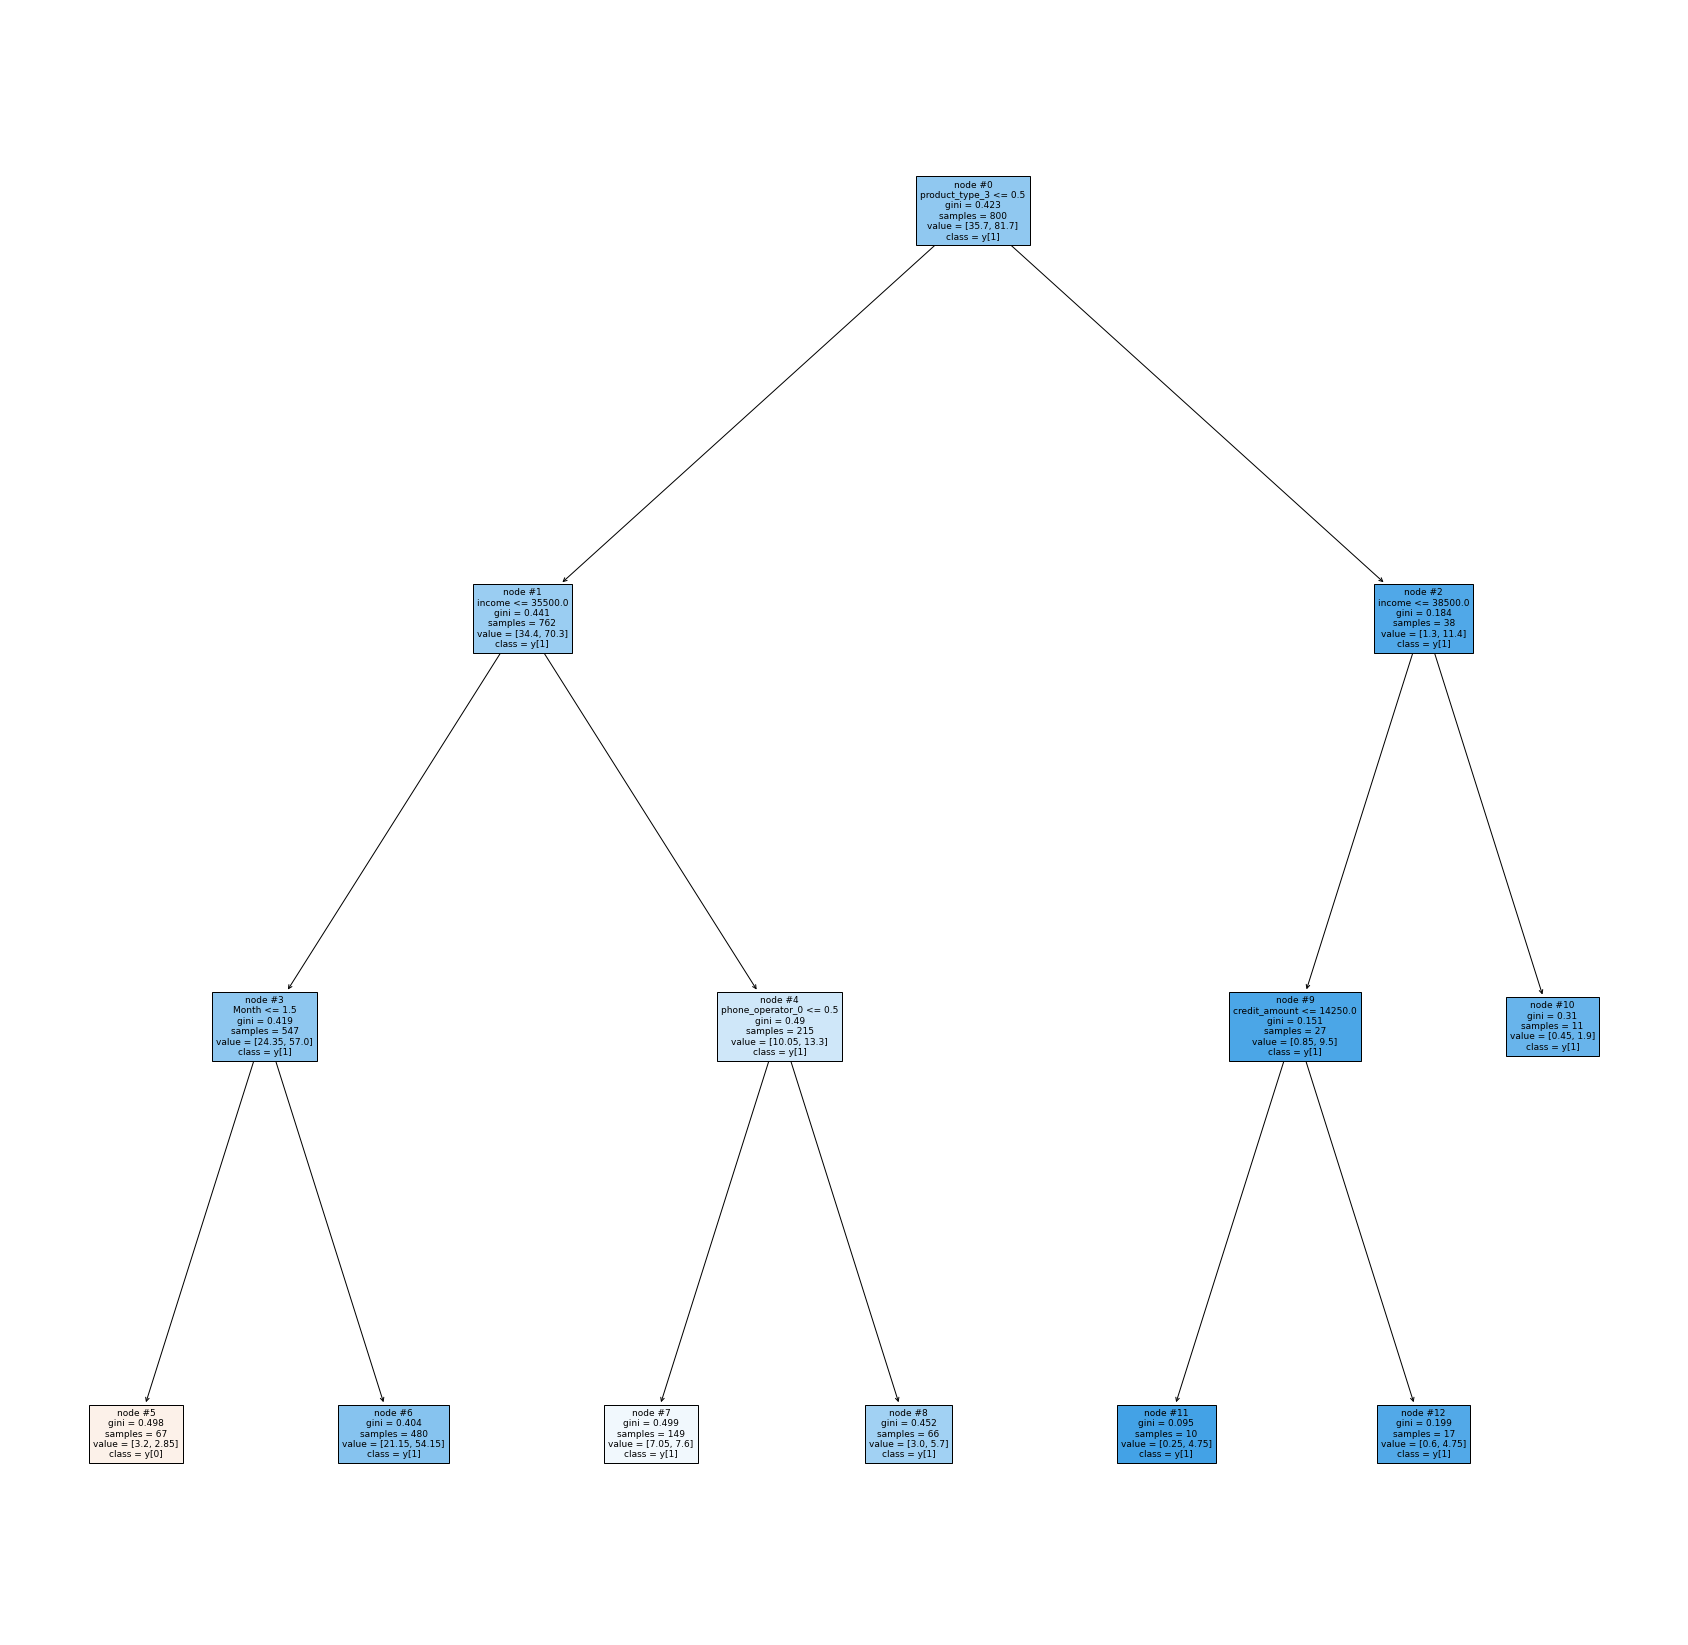

CPU times: total: 969 ms
Wall time: 1.11 s


In [20]:
%%time
plt.figure(figsize=(30, 30))
plot_tree(dt1_tuned, feature_names=X_train.columns.to_list(), filled=True, fontsize=9, node_ids=True, class_names=True)
plt.show()

In [21]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
dt1_tuned_train_perf = model_performance_classification_sklearn(dt1_tuned, X_train, y_train, threshold=0.5)
display(dt1_tuned_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
dt1_tuned_test_perf = model_performance_classification_sklearn(dt1_tuned, X_test, y_test, threshold=0.5)
display(dt1_tuned_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.18375,0.527376,0.965116,0.113233,0.202686,0.622109


Evaluation metrics on the testing dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.16,0.50971,0.952381,0.106952,0.192308,0.54017


## Randomized Search CV
* Random search is a tuning technique that attempts to compute the optimum values of hyperparameters randomly unlike grid search

In [22]:
%%time

# Choose the type of classifier. 
dt2 = DecisionTreeClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    # The maximum depth of the tree. If None, then nodes 
    # are expanded until all leaves are pure or until all leaves 
    # contain less than min_samples_split samples.
    "max_depth": np.arange(3, 9),
    # The minimum number of samples required to split an internal node
    "min_samples_split": [5, 10, 30, 50, 70],
    # The minimum number of samples required to be at a leaf node
    "min_samples_leaf": [5, 10, 15, 20],
    # The number of features to consider when looking for the best split
    "max_features": ['auto', 'sqrt', 'log2'],
    # Grow a tree with max_leaf_nodes in best-first fashion
    "max_leaf_nodes": [10, 25, 50, 100],
    # Weights associated with classes
    "class_weight": [{0:0.1, 1:0.9}, {0:0.05, 1:0.95}, {0:0.2, 1:0.8}]
    
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the randomized search
rand_obj_dt2 = RandomizedSearchCV(dt2, parameters, n_iter=10, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search

rand_obj_dt2 = rand_obj_dt2.fit(X_train, y_train)

# Print the best combination of parameters
rand_obj_dt2.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 15.6 ms
Wall time: 159 ms


{'min_samples_split': 10,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 10,
 'max_features': 'log2',
 'max_depth': 3,
 'class_weight': {0: 0.05, 1: 0.95}}

In [23]:
# # use the best combination of parameters to train the model
dt2_tuned = DecisionTreeClassifier(
            min_samples_split = rand_obj_dt2.best_params_['min_samples_split'],
            min_samples_leaf = rand_obj_dt2.best_params_['min_samples_leaf'],
            max_leaf_nodes = rand_obj_dt2.best_params_['max_leaf_nodes'],
            max_features = rand_obj_dt2.best_params_['max_features'],
            max_depth = rand_obj_dt2.best_params_['max_depth'],
            class_weight = rand_obj_dt2.best_params_['class_weight'],
            random_state = 42
)

# Fit the best model to the data.
dt2_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95}, max_depth=3,
                       max_features='log2', max_leaf_nodes=10,
                       min_samples_leaf=15, min_samples_split=10,
                       random_state=42)

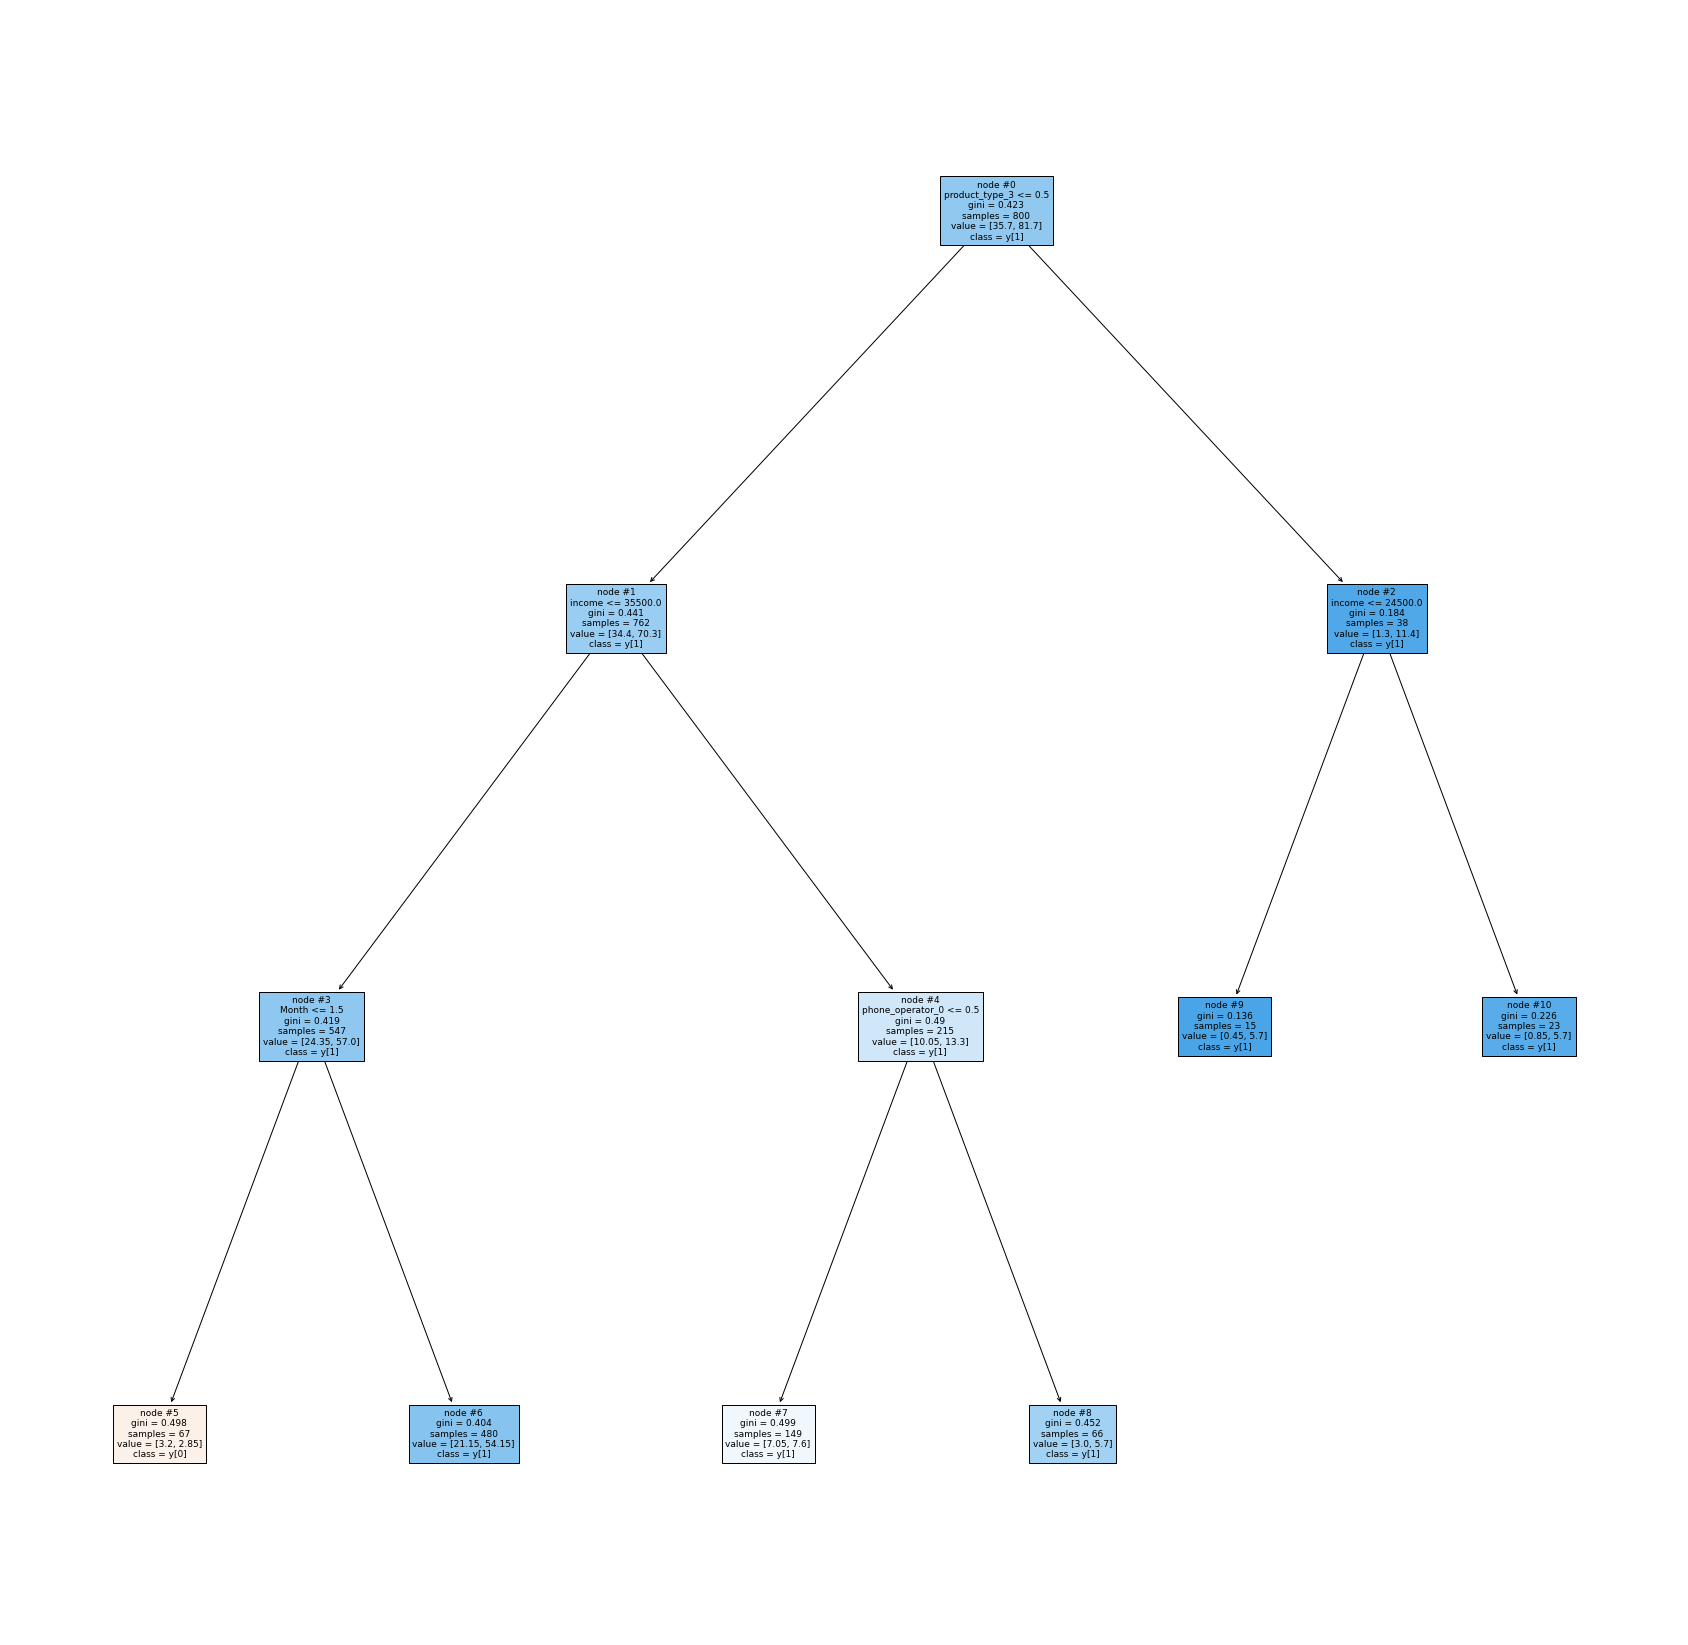

CPU times: total: 828 ms
Wall time: 974 ms


In [24]:
%%time
plt.figure(figsize=(30, 30))
plot_tree(dt2_tuned, feature_names=X_train.columns.to_list(), filled=True, fontsize=9, node_ids=True, class_names=True)
plt.show()

In [25]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
dt2_tuned_train_perf = model_performance_classification_sklearn(dt2_tuned, X_train, y_train, threshold=0.5)
display(dt2_tuned_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the validation dataset')
dt2_tuned_test_perf = model_performance_classification_sklearn(dt2_tuned, X_test, y_test, threshold=0.5)
display(dt2_tuned_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.18375,0.527376,0.965116,0.113233,0.202686,0.621759


Evaluation metrics on the validation dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.16,0.50971,0.952381,0.106952,0.192308,0.537909


# RandomForestClassifier

In [26]:
# model without hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
rf_train_perf = model_performance_classification_sklearn(rf, X_train, y_train, threshold=0.5)
display(rf_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
rf_test_perf = model_performance_classification_sklearn(rf, X_test, y_test, threshold=0.5)
display(rf_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,1.0,1.0,1.0,1.0,1.0,1.0


Evaluation metrics on the testing dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.965,0.833333,0.666667,1.0,0.8,0.975791


### Hyperparameters for RandomForestClassifier

In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [29]:
%%time

# Choose the type of classifier. 
rf1 = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    # number of trees in the forest
    "n_estimators": [15,20,25],
    # the minimum number of samples required to be at a leaf node
    "min_samples_leaf": np.arange(5, 10),
    # The number of features to consider when looking for the best split
    "max_features": np.arange(0.2, 0.7, 0.1),
    # If bootstrap is True (default), the number of samples to draw from X to train each base estimator.
    "max_samples": np.arange(0.3, 0.7, 0.1),
    # Weights associated with classes in the form
    "class_weight" : ['balanced', 'balanced_subsample'],
    # The maximum depth of the tree.
    "max_depth":np.arange(3,5),
    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    "min_impurity_decrease":[0.001, 0.002, 0.003]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the randomized search
rand_obj_rf1 = RandomizedSearchCV(rf1, parameters, n_iter=10, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search

rand_obj_rf1 = rand_obj_rf1.fit(X_train, y_train)

# Print the best combination of parameters
rand_obj_rf1.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 203 ms
Wall time: 913 ms


{'n_estimators': 25,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.003,
 'max_samples': 0.6000000000000001,
 'max_features': 0.2,
 'max_depth': 3,
 'class_weight': 'balanced'}

In [30]:
# # use the best combination of parameters to train the model
rf1_tuned = RandomForestClassifier(
    n_estimators = rand_obj_rf1.best_params_['n_estimators'],
    min_samples_leaf = rand_obj_rf1.best_params_['min_samples_leaf'],
    min_impurity_decrease = rand_obj_rf1.best_params_['min_impurity_decrease'],
    max_samples = rand_obj_rf1.best_params_['max_samples'],
    max_features = rand_obj_rf1.best_params_['max_features'],
    max_depth = rand_obj_rf1.best_params_['max_depth'],
    class_weight = rand_obj_rf1.best_params_['class_weight'],
    random_state = 42
)

# Fit the best model to the data.
rf1_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=0.2,
                       max_samples=0.6000000000000001,
                       min_impurity_decrease=0.003, min_samples_leaf=6,
                       n_estimators=25, random_state=42)

In [31]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
rf1_tuned_train_perf = model_performance_classification_sklearn(rf1_tuned, X_train, y_train, threshold=0.5)
display(rf1_tuned_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
rf1_tuned_test_perf = model_performance_classification_sklearn(rf1_tuned, X_test, y_test, threshold=0.5)
display(rf1_tuned_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.925,0.906846,0.883721,0.603175,0.716981,0.961305


Evaluation metrics on the testing dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.93,0.876829,0.809524,0.62963,0.708333,0.958234


In [32]:
%%time

# Choose the type of classifier. 
rf2 = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {"n_estimators": [15,20,25],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "class_weight" : ['balanced'],
    "max_depth":np.arange(3,5),
    "min_impurity_decrease":[0.001, 0.002, 0.003]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
rand_obj_rf2 = GridSearchCV(rf2, parameters, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search

rand_obj_rf2 = rand_obj_rf2.fit(X_train, y_train)

# Print the best combination of parameters
rand_obj_rf2.best_params_

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
CPU times: total: 21 s
Wall time: 1min 50s


{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': 0.4000000000000001,
 'max_samples': 0.6000000000000001,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 7,
 'n_estimators': 15}

In [33]:
# use the best combination of parameters to train the model
rf2_tuned = RandomForestClassifier(
    n_estimators = rand_obj_rf2.best_params_['n_estimators'],
    min_samples_leaf = rand_obj_rf2.best_params_['min_samples_leaf'],
    min_impurity_decrease = rand_obj_rf2.best_params_['min_impurity_decrease'],
    max_samples = rand_obj_rf2.best_params_['max_samples'],
    max_features = rand_obj_rf2.best_params_['max_features'],
    max_depth = rand_obj_rf2.best_params_['max_depth'],
    class_weight = rand_obj_rf2.best_params_['class_weight'],
    random_state = 42
)

# Fit the best model to the data.
rf2_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features=0.4000000000000001,
                       max_samples=0.6000000000000001,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       n_estimators=15, random_state=42)

In [34]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
rf2_tuned_train_perf = model_performance_classification_sklearn(rf2_tuned, X_train, y_train, threshold=0.5)
display(rf2_tuned_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
rf2_tuned_test_perf = model_performance_classification_sklearn(rf2_tuned, X_test, y_test, threshold=0.5)
display(rf2_tuned_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.93875,0.899209,0.848837,0.669725,0.748718,0.958236


Evaluation metrics on the testing dataset


,Accuracy,Balanced Accuracy,Recall,Precision,F1,AUC
0,0.94,0.882416,0.809524,0.68,0.73913,0.947592


In [35]:
# training performance comparison
models_train_comp_df = pd.concat(
    [dt_train_perf.T, dt1_tuned_train_perf.T, dt2_tuned_train_perf.T,
     rf_train_perf.T, rf1_tuned_train_perf.T, rf2_tuned_train_perf.T], axis=1,
)
models_train_comp_df.columns = [
    'dt', 'dt1_tuned', 'dt2_tuned',
    'rf', 'rf1_tuned','rf2_tuned',
]

print("Training performance comparison:")
display(models_train_comp_df)

# testing performance comparison
models_test_comp_df = pd.concat(
    [dt_test_perf.T, dt1_tuned_test_perf.T, dt2_tuned_test_perf.T,
     rf_test_perf.T, rf1_tuned_test_perf.T, rf2_tuned_test_perf.T], axis=1,
)
models_test_comp_df.columns = [
    'dt', 'dt1_tuned', 'dt2_tuned',
    'rf', 'rf1_tuned','rf2_tuned',
]

print("Testing performance comparison:")
display(models_test_comp_df)

Training performance comparison:


,dt,dt1_tuned,dt2_tuned,rf,rf1_tuned,rf2_tuned
Accuracy,1.0,0.183750,0.183750,1.0,0.925000,0.938750
Balanced Accuracy,1.0,0.527376,0.527376,1.0,0.906846,0.899209
Recall,1.0,0.965116,0.965116,1.0,0.883721,0.848837
Precision,1.0,0.113233,0.113233,1.0,0.603175,0.669725
F1,1.0,0.202686,0.202686,1.0,0.716981,0.748718
AUC,1.0,0.622109,0.621759,1.0,0.961305,0.958236


Testing performance comparison:


,dt,dt1_tuned,dt2_tuned,rf,rf1_tuned,rf2_tuned
Accuracy,0.965000,0.160000,0.160000,0.965000,0.930000,0.940000
Balanced Accuracy,0.875366,0.509710,0.509710,0.833333,0.876829,0.882416
Recall,0.761905,0.952381,0.952381,0.666667,0.809524,0.809524
Precision,0.888889,0.106952,0.106952,1.000000,0.629630,0.680000
F1,0.820513,0.192308,0.192308,0.800000,0.708333,0.739130
AUC,0.875366,0.540170,0.537909,0.975791,0.958234,0.947592


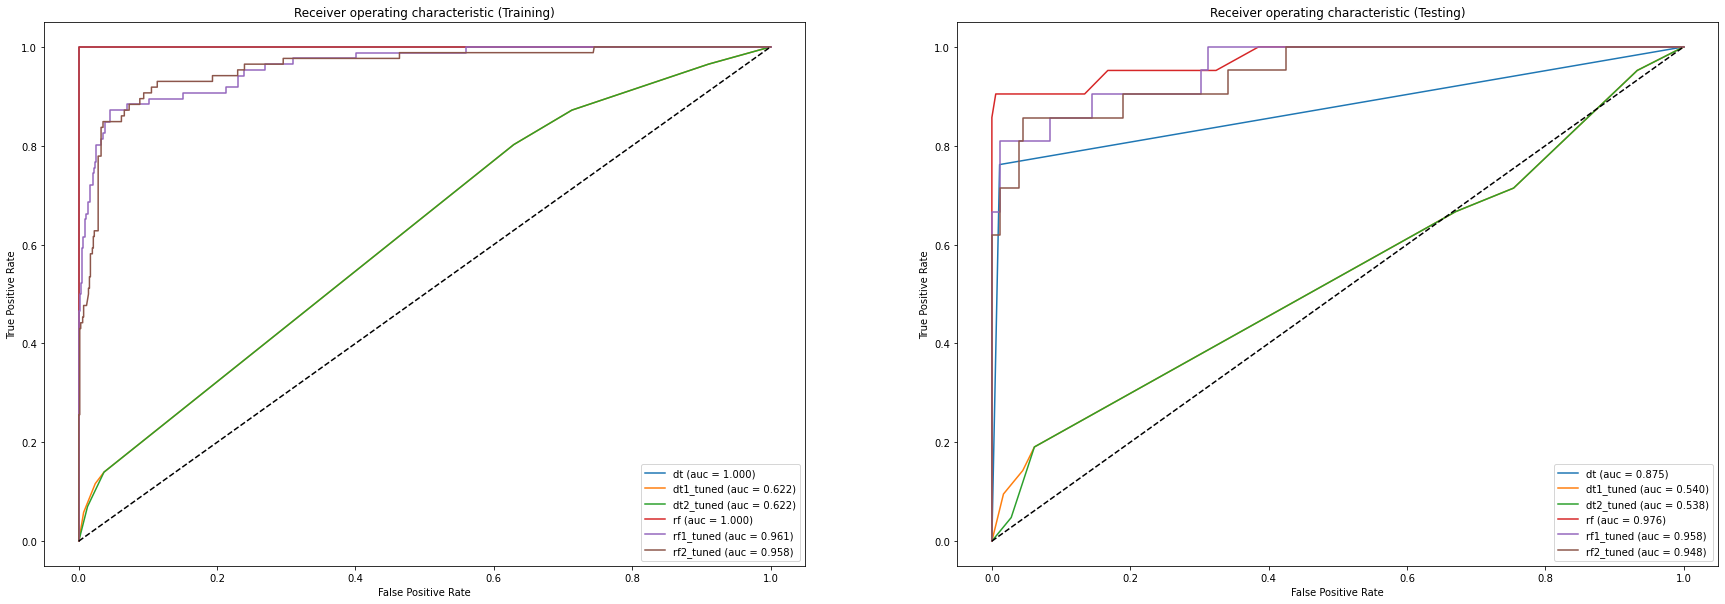

In [36]:
# ROC curve
model_names = ['dt', 'dt1_tuned', 'dt2_tuned', 'rf', 'rf1_tuned', 'rf2_tuned']
models = [dt, dt1_tuned, dt2_tuned, rf, rf1_tuned, rf2_tuned]
fpr_tpr_train = []
auc_train = []
fpr_tpr_test = []
auc_test = []
for i, model in enumerate(models):
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    fpr_train, tpr_train, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    fpr_tpr_train.append(fpr_train)
    fpr_tpr_train.append(tpr_train)
    auc_train.append('{} (auc = {:.3f})'.format(model_names[i], roc_auc_train))
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    fpr_test, tpr_test, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    fpr_tpr_test.append(fpr_test)
    fpr_tpr_test.append(tpr_test)
    auc_test.append('{} (auc = {:.3f})'.format(model_names[i], roc_auc_test))

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(*fpr_tpr_train)
plt.legend(auc_train, loc="lower right")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Training)")
plt.subplot(1, 2, 2)
plt.plot(*fpr_tpr_test)
plt.legend(auc_test, loc="lower right")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Testing)");